I have recently been looking into representing chemical routes as network graph objects and specifically directed acyclic graphs (DAGs). DAGs are a well known and established mathematical object, and available in python using the [networkx package](https://networkx.org/documentation/stable/index.html). 

The immediate problem I run into was their visualisation. While networkx is an excellent package for graph processing, the output of Matplotlib is far from ideal.

We will use the synthesis of [paracetamol as an example](https://en.wikipedia.org/wiki/Paracetamol#Chemistry), since I have done so [previously](https://chemicalg.github.io/2025/05/21/ChemicalStructuresWithBokeh.html) as well.

In [41]:
import numpy as np
import pandas as pd
import networkx as nx

from rdkit import Chem

import matplotlib.pyplot as plt

First, let's define the route:

The input file is split into input and output structures and names

In [64]:
data = pd.read_csv('Paracetamol.csv')

data

,Step,Input SMILES,Output SMILES,Input Name,Output Name
0,1,C1=CC=CC(=C1)OC,C1=C(C=CC(=C1)O[H])[N+](=O)[O-],1',2'
1,2,C1=C(C=CC(=C1)O[H])[N+](=O)[O-],C1=C(C=CC(=C1)O[H])N([H])[H],2',3'
2,3,C1=C(C=CC(=C1)O[H])N([H])[H],C1=C(C=CC(=C1)O[H])N([H])C(C)=O,3',TM


Great. Now let's define a function that can ingest the data and create a DAG object:

In [65]:
def RouteGraph(input_nodes, output_nodes):
    
    nodes_list = [pair for pair  in zip(input_nodes, output_nodes)]
    
    #construct the directed graph object    
    route = nx.DiGraph()
    route.add_edges_from(nodes_list)
    
    #validation
    if nx.is_directed_acyclic_graph(route):
        
        return route
    
    else:
        raise Exception('''
        RouteGraphException: 
        Route to Directed Graph transformation failed. 
        Check input and output nodes.
        ''')

In [66]:
route = RouteGraph(data['Input Name'], data['Output Name'])

Let's attempt to visualise the route with matplotlib:

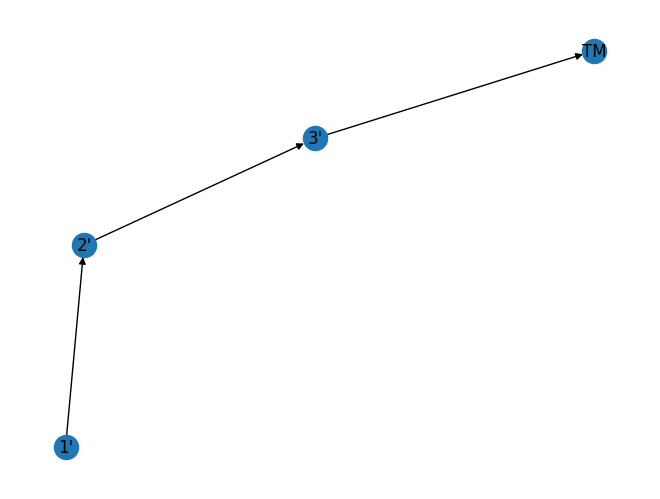

In [67]:
pos = nx.spring_layout(route, seed=3068)  # Seed layout for reproducibility
nx.draw(route, pos=pos, with_labels=True)
plt.show()

As you can see the above is not a straight line, if one does not provide a seed, then the graph changes. This is far from ideal. In general chemists like chemical routes spanning left-to-right, or top-to-bottom in schemes. Over the years, I have come to prefer top-to-bottom, as you can visualise long routes on a screen by exploiting scrolling. 

To understand what is happening, let's explore the "pos" variable we have just created:

In [68]:
pos

{"1'": array([-0.60419769, -0.94612353]),
 "2'": array([-0.54791957, -0.10262254]),
 "3'": array([0.15211726, 0.34143461]),
 'TM': array([1.        , 0.70731146])}

We can see that this is a dictionary object where the key is the graph node, and the value is an array of coordinates. As such we need a way of defining those coordinates reproducibly. To do that, we need to define two functions:

1. helper function that identifies starting materials (there may be multiple) and the product (there should only be one)
2. helper function that figures the correct path from each starting material to the product 
3. helper function that assigns a "step" value to each intermediate - for the starting material the step should be 0 and for the product it should be the length of the longest linear sequence. For routes with multiple branches (convergent), a "branch" variable should also be assigned.
4. helper visualisation function that brings the above together

In [69]:
#define function for start nodes, and end node
def FindSMsTM(route):
    
    ''' 
    Function that finds the starting materials and target molecule from each give route.
    
    Params:
    route: networkx DiGraph object
    
    Returns:
    SMs [list]: list of nodes that are starting materials.
    TM [list]: the target molecule as a list with 1 item. 
    
    '''
    
    start_nodes = [n for n, d in route.in_degree() if d == 0]
    end_node = [n for n, d in route.out_degree() if d == 0]
    
    return start_nodes, end_node

#define function to deconvolute route branches
def ValidBranches(route):
    
    '''
    Function to figure out the individual branches in each route.
    This is necessary because sometimes but not never, there may be a divergent node in a route.
    
    Params:
    route: networkx DiGraph object
    
    Returns:
    valid_branches [list]: nested list of branches with nodes for each branch as a list. 
    
    '''
    
    start_nodes, end_node = FindSMsTM(route)

    valid_branches = []

    for node in start_nodes:
        branches = nx.all_simple_paths(route, node, end_node)
        selected_branch = max(list(branches), key=len)
        valid_branches.append(selected_branch)
        
    return start_nodes, end_node, valid_branches

#define function to assign step number
def StepAssignment(route):
    
    '''
    Function to assign step number to each intermediate for visualisaton. 
    Modifies route (DiGraph) object in place. Adds branch number, layer number
    step number and whether a mocelule is a starting material, intermediate,
    or target molecule.

    Params:
    route: networkx DiGraph object
        
    Returns:
    None
    
    '''
   
    start_nodes, end_node, valid_branches = ValidBranches(route)
    
    LLS_len = nx.dag_longest_path_length(route)
    
    for node in route.nodes:
        for branch in valid_branches:
            branch_number = valid_branches.index(branch) + 1
            branch_len = len(branch)
            if node in branch:
                if node == end_node[0]:
                    route.nodes[node]["branch"] = 1
                    route.nodes[node]["step"] = 0
                    
                else:
                    if route.nodes[node].get("branch") == None:
                        route.nodes[node]["branch"] = branch_number
                        
                    step = branch_len - branch.index(node)
                    route.nodes[node]["step"] = step
                    
                if node == end_node[0]:
                    route.nodes[node]["Role"] = 'Target Molecule'
                    
                elif node in start_nodes:
                    route.nodes[node]["Role"] = 'Starting Material'
                    
                else:
                    route.nodes[node]["Role"] = 'Intermediate'          
    
    return None

#define function to visualist route
def RouteGraphFig(route):

    '''
    Function to figure out the individual branches in each route.
    
    Params:
    route: networkx DiGraph object
    
    Returns:
    fig, ax: matplotlib objects
    
    '''
    
    StepAssignment(route) # assign the steps

    pos = {node: (route.nodes[node]["branch"],
                  route.nodes[node]["step"]) 
              for node in route.nodes}

    fig, ax = plt.subplots(figsize=(len(pos),len(pos)*2))
    nx.draw_networkx(route, pos=pos, ax=ax, arrows=True, node_shape = "s", node_color = "white")
    ax.set_title("Route Graph")
    fig.tight_layout()

    return fig, ax

Now let's use them:

In [70]:
sm, tm = FindSMsTM(route)

tm # make sure there is only one end node (target mol)

['TM']

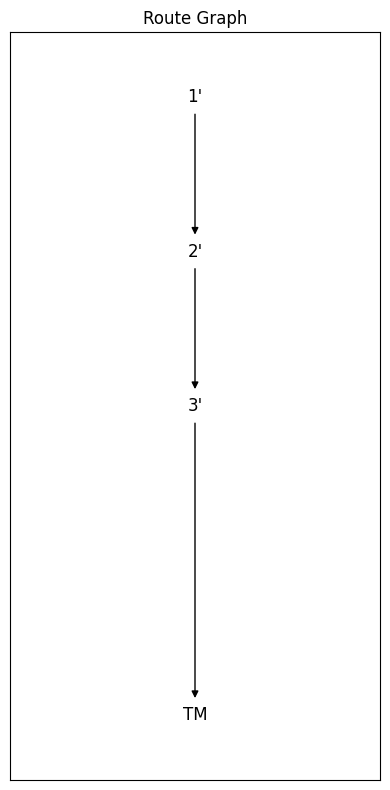

In [71]:
fig, ax = RouteGraphFig(route)

plt.show()

Isn't this lovely ?!

What's more is that we can change the RouteGraphFig function to give a left-to-right visualisation by just passing the "branch" and "step" variables in different order to the "pos" dictionary comprehension:

In [72]:
def RouteGraphFigLR(route):

    '''
    Function to figure out the individual branches in each route.
    
    Params:
    route: networkx DiGraph object
    
    Returns:
    fig, ax: matplotlib objects
    
    '''
    
    StepAssignment(route) # assign the steps

    pos = {node: (route.nodes[node]["step"],
                  route.nodes[node]["branch"]) 
              for node in route.nodes}

    fig, ax = plt.subplots(figsize=(len(pos)*2,len(pos)))
    nx.draw_networkx(route, pos=pos, ax=ax, arrows=True, node_shape = "s", node_color = "white")
    ax.set_title("Route Graph")
    fig.tight_layout()

    return fig, ax

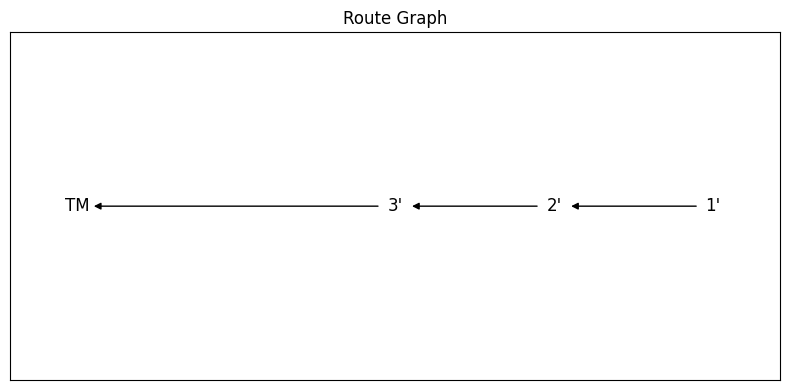

In [73]:
fig, ax = RouteGraphFigLR(route)

plt.show()

 ... or so I thought ...
 
 In this case we can add a "layer" variable in the StepAssignment function as follows:

In [74]:
def StepAssignment(route):
    
    '''
    Function to assign step number to each intermediate for visualisaton. 
    Modifies route (DiGraph) object in place. Adds branch number, layer number
    step number and whether a mocelule is a starting material, intermediate,
    or target molecule.

    Params:
    route: networkx DiGraph object
        
    Returns:
    None
    
    '''
   
    start_nodes, end_node, valid_branches = ValidBranches(route)
    
    LLS_len = nx.dag_longest_path_length(route)
    
    for node in route.nodes:
        for branch in valid_branches:
            branch_number = valid_branches.index(branch) + 1
            branch_len = len(branch)
            if node in branch:
                if node == end_node[0]:
                    route.nodes[node]["branch"] = 1
                    route.nodes[node]["layer"] = LLS_len
                    route.nodes[node]["step"] = 0
                    
                else:
                    if route.nodes[node].get("branch") == None:
                        route.nodes[node]["branch"] = branch_number
                        
                    layer = LLS_len - branch_len + branch.index(node) + 1 
                    route.nodes[node]["layer"] = layer
                    step = branch_len - branch.index(node)
                    route.nodes[node]["step"] = step
                    
                if node == end_node[0]:
                    route.nodes[node]["Role"] = 'Target Molecule'
                    
                elif node in start_nodes:
                    route.nodes[node]["Role"] = 'Starting Material'
                    
                else:
                    route.nodes[node]["Role"] = 'Intermediate'          
    
    return None

and change the RouteGraphFigLR to use the "layer" variable:

In [75]:
def RouteGraphFigLR(route):

    '''
    Function to figure out the individual branches in each route.
    
    Params:
    route: networkx DiGraph object
    
    Returns:
    fig, ax: matplotlib objects
    
    '''
    
    StepAssignment(route) # assign the steps

    pos = {node: (route.nodes[node]["layer"], ### <---- This is the change here!!!
                  route.nodes[node]["branch"]) 
              for node in route.nodes}

    fig, ax = plt.subplots(figsize=(len(pos)*2,len(pos)))
    nx.draw_networkx(route, pos=pos, ax=ax, arrows=True, node_shape = "s", node_color = "white")
    ax.set_title("Route Graph")
    fig.tight_layout()

    return fig, ax

So now if we put the two together:

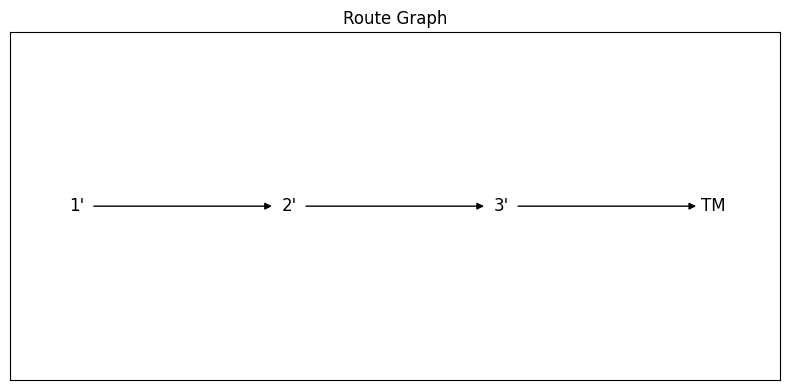

In [76]:
fig, ax = RouteGraphFigLR(route)

plt.show()

There we go! 

In reality I would prefer the nodes to have the chemical structure. Let's see how we can do that.

First, let's define a function to construct a dataframe from the DAG:

In [77]:
def RouteDataFrame(route, route_data):
    
    start_nodes, end_node = FindSMsTM(route)
    
    inputs = route_data[['Input Name', 'Input SMILES']
                 ].loc[route_data['Input Name'].isin(list(route.nodes))
                      ].drop_duplicates('Input Name')
    
    outputs = route_data[['Output Name','Output SMILES']
                  ].loc[route_data['Output Name'].isin(end_node)]
    
    route_df = pd.DataFrame(np.concatenate((inputs.values, outputs.values)), columns = ['Compound', 'SMILES'])
    
    route_df['Step'] = [route.nodes[node]['step'] for node in route_df['Compound']]
    route_df['Role'] = [route.nodes[node]['Role'] for node in route_df['Compound']]
    
    return route_df

This route dataframe can hold multiple other information, for example physical properties

In [78]:
route_df = RouteDataFrame(route, data)

In [79]:
route_df

,Compound,SMILES,Step,Role
0,1',C1=CC=CC(=C1)OC,4,Starting Material
1,2',C1=C(C=CC(=C1)O[H])[N+](=O)[O-],3,Intermediate
2,3',C1=C(C=CC(=C1)O[H])N([H])[H],2,Intermediate
3,TM,C1=C(C=CC(=C1)O[H])N([H])C(C)=O,0,Target Molecule


Now let's define a function that can ingest the dataframe and the graph and produce the visualisation: 

In [82]:
def RouteGraphWithStructures(route, route_df):
    StepAssignment(route) # assign the steps

    pos = {node: (route.nodes[node]["branch"],
                  route.nodes[node]["step"]) 
              for node in route.nodes}
    
    mols_l = [Chem.MolFromSmiles(smi) for smi in route_df['SMILES']]
    
    imgs_l = [Chem.Draw.MolToImage(mol) for mol in mols_l]
    
    fig, ax = plt.subplots(figsize=(len(pos),len(pos)*2))
    nx.draw_networkx(route, pos=pos, ax=ax, arrows=True, node_shape = "s", node_color = "white")

    ax=plt.gca()
    fig=plt.gcf()

    # Transform from data coordinates (scaled between xlim and ylim) to display coordinates
    trans = ax.transData.transform
    # Transform from display to figure coordinates
    trans2 = fig.transFigure.inverted().transform

    imsize = 0.15 # this is the image size

    # Add the respective image to each node
    for node, image in zip(route_df['Compound'], imgs_l):
        route.nodes[node]['image'] = image
        (x,y) = pos[node]
        xx,yy = trans((x,y)) # figure coordinates
        xa,ya = trans2((xx,yy)) # axes coordinates
        a = plt.axes([xa-imsize/2.0,ya-imsize/2.0, imsize, imsize])


        a.imshow(route.nodes[node]['image'])
        a.set_aspect('equal')
        a.axis("off")

    ax.set_title("Route Graph")
    #fig.tight_layout()
    
    return fig, ax   

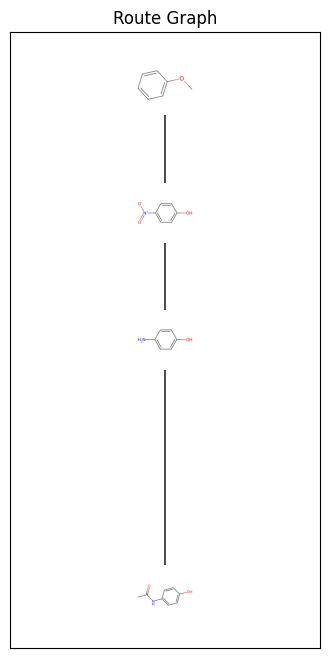

In [83]:
fig, ax = RouteGraphWithStructures(route, route_df)

This is great. The synthesis of paracetamol is very simple as an example. It would be great to see this code applied to more complex and longer routes. 

Let me know if you find this useful.